# Multi-Algorithm Comparison – Grid Search Results


In [1]:
import sqlite3
import json
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Make plots a bit larger by default
plt.rcParams['figure.figsize'] = (7, 5)

DATA_DIR = "."  # adjust if needed


In [2]:
def load_runs_simple(db_filename, algo_label=None):
    """Load simple grid-search results (GA, SA, mu+lambda) from a SQLite DB.

    Expected schema:
        runs(id INTEGER PRIMARY KEY,
             algo TEXT,
             seed INTEGER,
             params TEXT (JSON),
             score REAL,
             time_sec REAL)
    """
    path = os.path.join(DATA_DIR, db_filename)
    conn = sqlite3.connect(path)
    df = pd.read_sql_query("SELECT * FROM runs", conn)
    conn.close()

    if algo_label is not None:
        df["algo_label"] = algo_label

    # Parse JSON parameter dicts into separate columns
    def parse_params(p):
        if isinstance(p, str):
            try:
                return json.loads(p)
            except json.JSONDecodeError:
                return {}
        return {}

    params_parsed = df["params"].apply(parse_params)
    params_df = pd.json_normalize(params_parsed)
    params_df.columns = [f"param_{c}" for c in params_df.columns]

    df = pd.concat([df, params_df], axis=1)
    return df


def load_nsga2(db_filename):
    """Load NSGA-II grid-search results.

    Expected schema:
      runs(id, pop_size, ngen, cxpb, mutpb, seed,
           hv, clean, penalized, conflicts, mindist, feasible, time_sec)

      pareto_fronts(run_id, f1, f2)  # one row per Pareto point, per run
    """
    path = os.path.join(DATA_DIR, db_filename)
    conn = sqlite3.connect(path)
    runs = pd.read_sql_query("SELECT * FROM runs", conn)
    pareto = pd.read_sql_query("SELECT * FROM pareto_fronts", conn)
    conn.close()
    return runs, pareto


In [3]:
# Adjust these paths if the DB files are in a subfolder
ga_df  = load_runs_simple("grid_results_ga.db",        algo_label="GA")
sa_df  = load_runs_simple("grid_results_sa.db",        algo_label="SA")
mu_df  = load_runs_simple("grid_results_mulambda.db",  algo_label="Mu+Lambda")

ns_runs, ns_pf = load_nsga2("nsga2_grid.db")

ga_df.head(), sa_df.head(), mu_df.head(), ns_runs.head(), ns_pf.head()

(   id algo  seed                                             params  \
 0   1   ga     0  {"pop_size": 80, "ngen": 300, "cxpb": 0.5, "mu...   
 1   2   ga     2  {"pop_size": 80, "ngen": 300, "cxpb": 0.5, "mu...   
 2   3   ga     1  {"pop_size": 80, "ngen": 300, "cxpb": 0.7, "mu...   
 3   4   ga     0  {"pop_size": 80, "ngen": 300, "cxpb": 0.8, "mu...   
 4   5   ga     1  {"pop_size": 80, "ngen": 300, "cxpb": 0.5, "mu...   
 
          score    time_sec algo_label  param_pop_size  param_ngen  param_cxpb  \
 0  2011.901370   60.784242         GA              80         300         0.5   
 1  1271.478282   94.196682         GA              80         300         0.5   
 2  1341.892496   95.324807         GA              80         300         0.7   
 3  1476.413059  105.502454         GA              80         300         0.8   
 4  1487.864069   63.836327         GA              80         300         0.5   
 
    param_mutpb  
 0          0.1  
 1          0.5  
 2          0.5  


## 1. Summary statistics per algorithm (single-objective)

We first compare the distribution of penalized distance (`score`) for:

- GA
- SA
- $(\mu+\lambda)$ Evolution Strategy


In [4]:
single_df = pd.concat([ga_df, sa_df, mu_df], ignore_index=True)

# Basic statistics: best, mean, std of penalized distance (score) per algorithm
stats = (
    single_df
    .groupby("algo_label")["score"]
    .agg(["min", "mean", "std", "median", "count"])
    .reset_index()
    .sort_values("min")
)
print("Penalized distance statistics (lower is better):")
display(stats)


Penalized distance statistics (lower is better):


,algo_label,min,mean,std,median,count
1,Mu+Lambda,1104.658730,1446.585517,223.594809,1420.420418,243
0,GA,1184.629292,1453.529595,215.902650,1400.684126,243
2,SA,1989.316882,2297.899444,205.839455,2329.367388,27


<Figure size 700x500 with 0 Axes>

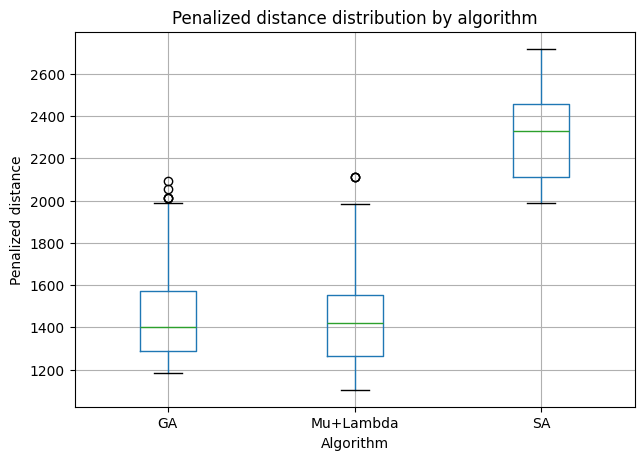

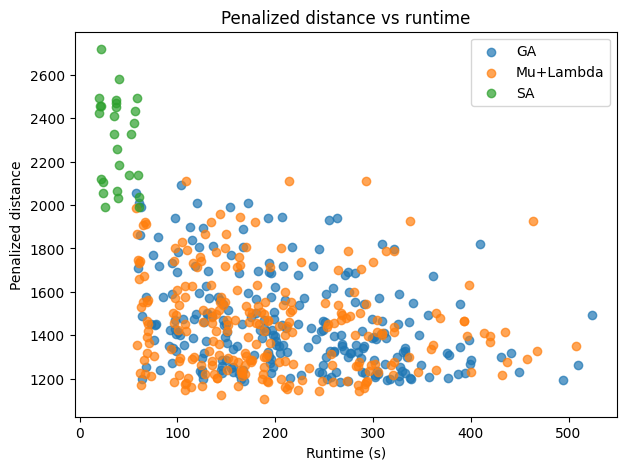

In [5]:
# Boxplot of penalized distance by algorithm
plt.figure()
single_df.boxplot(column="score", by="algo_label")
plt.title("Penalized distance distribution by algorithm")
plt.suptitle("")
plt.xlabel("Algorithm")
plt.ylabel("Penalized distance")
plt.show()

# Scatter of penalized distance vs runtime
plt.figure()
for name, sub in single_df.groupby("algo_label"):
    plt.scatter(sub["time_sec"], sub["score"], label=name, alpha=0.7)
plt.xlabel("Runtime (s)")
plt.ylabel("Penalized distance")
plt.title("Penalized distance vs runtime")
plt.legend()
plt.show()


### Top configurations per algorithm

Below we list the best few configurations (according to penalized distance) for each algorithm.


In [6]:
def show_top_configs(df, algo_label, k=10):
    print(f"\n=== {algo_label}: top {k} configurations by penalized distance ===")
    cols = ["id", "seed", "score", "time_sec"] + [c for c in df.columns if c.startswith("param_")]
    display(df.sort_values("score").head(k)[cols])

show_top_configs(ga_df,  "GA")
show_top_configs(sa_df,  "SA")
show_top_configs(mu_df,  "Mu+Lambda")



=== GA: top 10 configurations by penalized distance ===


,id,seed,score,time_sec,param_pop_size,param_ngen,param_cxpb,param_mutpb
239,240,1,1184.629292,266.195402,150,800,0.8,0.3
191,192,0,1187.650865,167.844637,150,300,0.8,0.3
236,237,0,1187.650865,274.088331,150,800,0.8,0.3
196,197,0,1187.650865,326.619603,150,600,0.8,0.3
202,203,1,1193.986147,314.151039,150,600,0.8,0.3
204,205,2,1195.227272,493.980041,150,800,0.5,0.5
140,141,1,1196.028787,338.494621,120,800,0.5,0.3
89,90,1,1196.028787,252.964100,120,600,0.5,0.3
238,239,0,1197.049350,317.519262,150,800,0.5,0.5
45,46,1,1197.514574,164.845098,80,800,0.7,0.1



=== SA: top 10 configurations by penalized distance ===


,id,seed,score,time_sec,param_n_iter,param_start_temp,param_end_temp
8,9,2,1989.316882,26.124073,5000,20,0.01
20,21,1,1991.069913,61.203794,12000,5,0.01
12,13,1,2033.248340,38.976210,8000,5,0.01
23,24,1,2039.126767,60.946672,12000,10,0.01
6,7,1,2055.097835,23.640593,5000,5,0.01
14,15,1,2067.333621,38.363352,8000,10,0.01
7,8,1,2107.054689,23.702275,5000,10,0.01
5,6,1,2118.297330,22.234219,5000,20,0.01
25,26,1,2139.625252,50.969040,12000,20,0.01
21,22,2,2141.109523,59.776182,12000,5,0.01



=== Mu+Lambda: top 10 configurations by penalized distance ===


,id,seed,score,time_sec,param_mu,param_lambda_,param_ngen,param_cxpb,param_mutpb
171,172,0,1104.658730,188.176127,120,50,800,0.5,0.5
141,142,0,1126.272943,145.029787,120,50,600,0.5,0.5
226,227,0,1144.157720,245.171990,120,80,800,0.5,0.5
57,58,0,1144.364069,285.593215,50,80,800,0.5,0.5
193,194,0,1146.157720,107.485945,120,80,300,0.5,0.5
198,199,0,1146.157720,223.315636,120,80,600,0.5,0.5
31,32,0,1151.778282,212.263355,50,80,600,0.5,0.5
153,154,1,1156.371933,290.917879,80,80,800,0.5,0.5
123,124,1,1162.200360,210.544376,80,80,600,0.5,0.5
30,31,0,1163.156709,113.870339,50,80,300,0.5,0.5


## 2. NSGA-II grid search analysis

For NSGA-II we analyze:

- Hypervolume (`hv`) per configuration (to be **maximized** in principle, although you may also work with its negative if you used it as a loss).
- Feasibility, conflicts and penalized distance.
- Pareto fronts for selected runs.


In [7]:
# Keep track of feasibility if present (1 = feasible)
print("NSGA-II runs (first rows):")
display(ns_runs.head())

# Basic statistics for hypervolume and penalized distance
ns_stats = (
    ns_runs
    .groupby(["pop_size", "ngen", "cxpb", "mutpb"])
    .agg(
        mean_hv=("hv", "mean"),
        std_hv=("hv", "std"),
        mean_pen=("penalized", "mean"),
        std_pen=("penalized", "std"),
        n_runs=("id", "count"),
    )
    .reset_index()
    .sort_values("mean_hv", ascending=False)
)
print("NSGA-II configuration summary (sorted by mean hypervolume, descending):")
display(ns_stats.head(10))


NSGA-II runs (first rows):


,id,pop_size,ngen,cxpb,mutpb,seed,hv,clean,penalized,conflicts,mindist,feasible,time_sec
0,1,50,300,0.7,0.3,2,1.281458e+07,1093.021428,1760.071428,3,5.000000,0,42.705268
1,2,50,300,0.6,0.4,0,1.374909e+07,1101.050865,1530.550865,2,5.000000,0,46.744138
2,3,50,500,0.7,0.2,0,1.358141e+07,1079.565584,1566.715584,2,5.000000,0,58.387695
3,4,50,500,0.6,0.4,1,1.416145e+07,1161.121933,1409.421933,0,6.082763,1,76.151384
4,5,50,300,0.7,0.2,0,1.259513e+07,1075.979797,1850.729797,5,3.605551,0,33.767158


NSGA-II configuration summary (sorted by mean hypervolume, descending):


,pop_size,ngen,cxpb,mutpb,mean_hv,std_hv,mean_pen,std_pen,n_runs
142,120,1000,0.8,0.3,1.522559e+07,132296.556993,1145.588768,32.536056,3
133,120,800,0.8,0.3,1.520573e+07,148977.619906,1150.005435,36.808280,3
105,100,1000,0.8,0.2,1.518474e+07,239543.391831,1154.548075,57.477278,3
136,120,1000,0.6,0.3,1.516146e+07,67408.008152,1163.100697,17.041975,3
127,120,800,0.6,0.3,1.515512e+07,63236.960655,1164.238768,16.016554,3
139,120,1000,0.7,0.3,1.514821e+07,123006.715520,1165.798412,31.198143,3
107,100,1000,0.8,0.4,1.512848e+07,229639.415888,1174.433525,58.394795,3
130,120,800,0.7,0.3,1.512741e+07,92598.404281,1170.722101,23.603978,3
118,120,500,0.6,0.3,1.512590e+07,48092.703624,1171.322101,12.442303,3
101,100,1000,0.6,0.4,1.512149e+07,138437.815193,1173.314910,34.277057,3


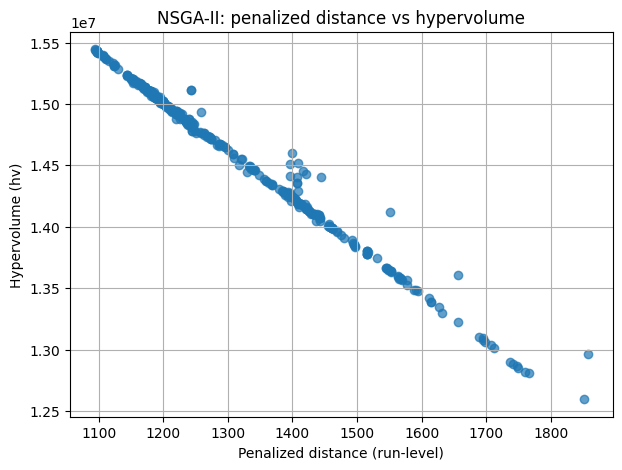

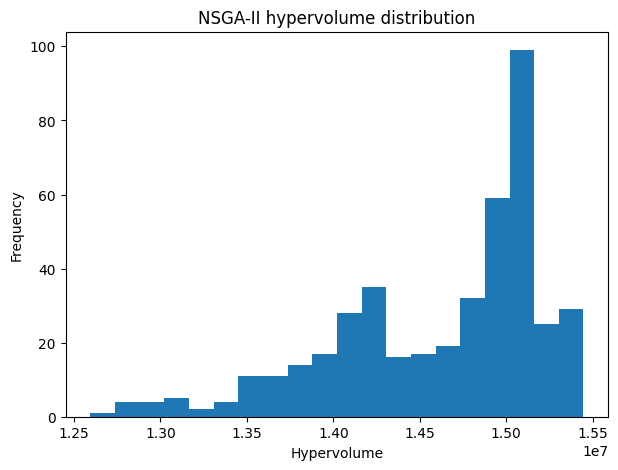

In [8]:
# Scatter: hypervolume vs penalized distance (one point per run)
plt.figure()
plt.scatter(ns_runs["penalized"], ns_runs["hv"], alpha=0.7)
plt.xlabel("Penalized distance (run-level)")
plt.ylabel("Hypervolume (hv)")
plt.title("NSGA-II: penalized distance vs hypervolume")
plt.grid(True)
plt.show()

# Distribution of hv across all runs
plt.figure()
plt.hist(ns_runs["hv"], bins=20)
plt.xlabel("Hypervolume")
plt.ylabel("Frequency")
plt.title("NSGA-II hypervolume distribution")
plt.show()


Best NSGA-II run by hypervolume:


id           4.100000e+02
pop_size     1.200000e+02
ngen         1.000000e+03
cxpb         6.000000e-01
mutpb        2.000000e-01
seed         2.000000e+00
hv           1.544623e+07
clean        1.077323e+03
penalized    1.093873e+03
conflicts    0.000000e+00
mindist      6.082763e+00
feasible     1.000000e+00
time_sec     1.987164e+02
Name: 409, dtype: float64

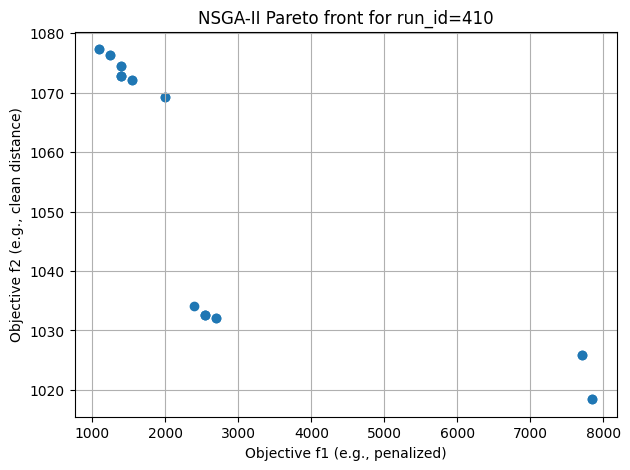

In [9]:
# Identify the run with best (maximum) hypervolume
best_run_idx = ns_runs["hv"].idxmax()
best_run_id  = int(ns_runs.loc[best_run_idx, "id"])
best_cfg     = ns_runs.loc[best_run_idx]

print("Best NSGA-II run by hypervolume:")
display(best_cfg)

# Extract its Pareto front
best_pf = ns_pf[ns_pf["run_id"] == best_run_id].copy()

plt.figure()
plt.scatter(best_pf["f1"], best_pf["f2"])
plt.xlabel("Objective f1 (e.g., penalized)")
plt.ylabel("Objective f2 (e.g., clean distance)")
plt.title(f"NSGA-II Pareto front for run_id={best_run_id}")
plt.grid(True)
plt.show()
